In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data_train = pd.read_csv('/content/drive/MyDrive/Dataset/DailyDelhiClimateTrain.csv')
data_train.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [4]:
data_train.isnull().sum() #mengecek adakah nilai yang hilang pada dataset

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

1. dates = data_train['date'].values: Baris ini mengambil nilai dari kolom 'date' dari DataFrame data_train dan menyimpannya dalam variabel dates.

2. temp = data_train['meantemp'].values: Baris ini mengambil nilai dari kolom 'meantemp' dari DataFrame data_train dan menyimpannya dalam variabel temp.

3. plt.figure(figsize=(15,5)): Baris ini membuat gambar baru dengan ukuran (15, 5) dalam satuan inch. Ini akan menjadi gambar tempat grafik akan digambar.

4. plt.plot(dates, temp): Baris ini membuat plot garis dengan sumbu x yang diberikan oleh dates dan sumbu y yang diberikan oleh temp. Plot ini akan menunjukkan hubungan antara tanggal (sumbu x) dan suhu rata-rata (sumbu y) dari data yang disediakan.

5. plt.title('Temperature average', fontsize=20): Baris ini menambahkan judul ke plot yang telah dibuat. Judulnya adalah 'Temperature average' dengan ukuran font sebesar 20.

Dengan menjalankan baris kode ini, Anda akan membuat plot garis dari data suhu rata-rata terhadap tanggal dan menambahkan judul ke plot tersebut.

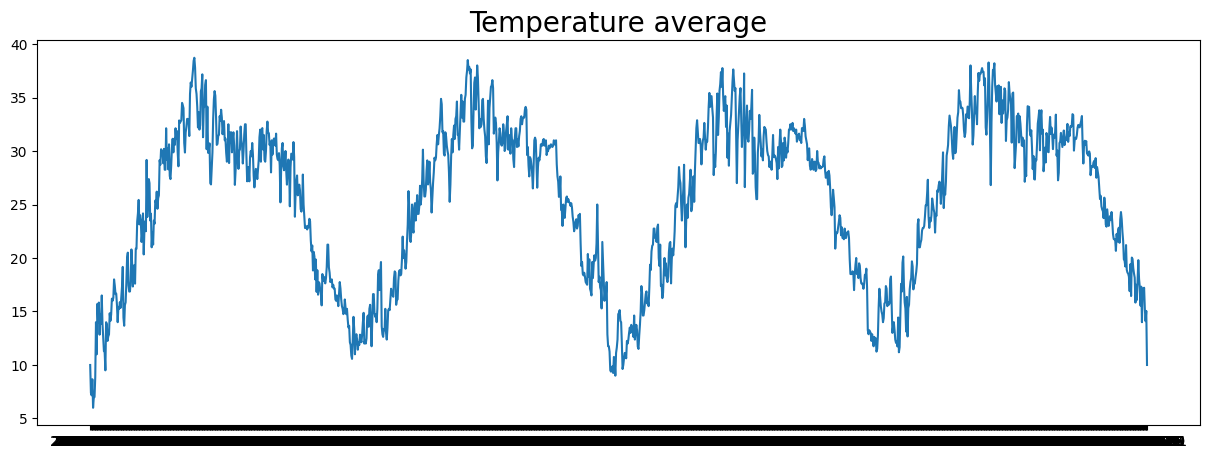

In [5]:
#membuat plot data
dates = data_train['date'].values
temp  = data_train['meantemp'].values


plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

Fungsi `windowed_dataset` ini secara khusus dirancang untuk memproses rangkaian data waktu atau urutan menjadi bentuk yang dapat digunakan untuk melatih model jaringan saraf. Berikut adalah penjelasan setiap baris kode:

1. `series = tf.expand_dims(series, axis=-1)`: Kode ini menambahkan dimensi baru di posisi terakhir menggunakan fungsi `tf.expand_dims` dari TensorFlow. Hal ini umum dilakukan dalam masalah seri waktu untuk menyesuaikan format data dengan model yang membutuhkan dimensi khusus.

2. `ds = tf.data.Dataset.from_tensor_slices(series)`: Baris ini membuat dataset dari tensor menggunakan `tf.data.Dataset.from_tensor_slices`. Ini membantu dalam mengonversi data menjadi bentuk yang sesuai untuk pemrosesan lebih lanjut.

3. `ds = ds.window(window_size + 1, shift=1, drop_remainder=True)`: Kode ini membagi dataset menjadi jendela dengan ukuran tertentu, menggunakan `window_size` sebagai ukuran jendela, dan `shift=1` menandakan pergeseran jendela sebesar 1. Parameter `drop_remainder=True` digunakan untuk memastikan bahwa semua jendela memiliki ukuran yang sama.

4. `ds = ds.flat_map(lambda w: w.batch(window_size + 1))`: Fungsi `flat_map` digunakan di sini untuk mengubah dataset menjadi satu dimensi dan `lambda w: w.batch(window_size + 1)` mengatur setiap elemen dataset ke dalam batch dengan ukuran yang telah ditentukan.

5. `ds = ds.shuffle(shuffle_buffer)`: Kode ini mengacak dataset dengan jumlah elemen yang ditentukan oleh `shuffle_buffer`. Ini berguna untuk melatih model secara efektif dengan memastikan bahwa urutan data tidak menjadi faktor yang mempengaruhi pembelajaran.

6. `ds = ds.map(lambda w: (w[:-1], w[-1:]))`: Kode ini menerapkan fungsi pemetaan pada setiap elemen dataset. Fungsi ini mengambil setiap jendela, membaginya menjadi fitur dan label, dan mengembalikan pasangan fitur-label.

7. `return ds.batch(batch_size).prefetch(1)`: Kode ini menggabungkan elemen-elemen dataset ke dalam batch yang lebih besar dengan ukuran yang ditentukan oleh `batch_size`. Selain itu, `prefetch(1)` mengoptimalkan penggunaan sumber daya dengan memastikan batch berikutnya siap saat batch saat ini sedang diproses.

Fungsi ini secara keseluruhan berguna untuk membuat dataset terstruktur yang cocok untuk pelatihan model jaringan saraf. Ini mengambil serangkaian data waktu atau urutan dan mengubahnya menjadi bentuk yang sesuai untuk digunakan dalam model yang memerlukan masukan urutan. Setiap langkahnya membantu mengonversi data mentah menjadi format yang lebih mudah untuk digunakan dalam pembelajaran mesin.

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Membuat dimensi baru di posisi terakhir dengan menggunakan tf.expand_dims
    series = tf.expand_dims(series, axis=-1)
    # Membuat dataset dari tensor dengan menggunakan tf.data.Dataset.from_tensor_slices
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Memecah dataset menjadi jendela dengan ukuran tertentu dengan menggunakan ds.window
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # Mengubah dataset menjadi satu dimensi dengan menggunakan ds.flat_map
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # Mengacak dataset dengan menggunakan ds.shuffle
    ds = ds.shuffle(shuffle_buffer)
    # Menerapkan fungsi pemetaan pada setiap elemen dataset dengan menggunakan ds.map
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    # Menggabungkan elemen-elemen dataset ke dalam batch yang lebih besar dengan menggunakan ds.batch
    # dan menyiapkan batch berikutnya saat ini sedang diproses dengan menggunakan ds.prefetch
    return ds.batch(batch_size).prefetch(1)


Di sini, Anda memiliki dua bagian kode terpisah yang terkait erat. Mari kita bahas masing-masing bagian:

1. `train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)`: Kode ini memanggil fungsi `windowed_dataset` yang telah didefinisikan sebelumnya. Fungsi ini digunakan untuk memproses data seri waktu atau urutan menjadi format yang dapat digunakan untuk melatih model jaringan saraf. Dalam contoh ini, `temp` adalah data input, `window_size=60` menunjukkan ukuran jendela, `batch_size=100` menunjukkan ukuran batch, dan `shuffle_buffer=1000` menunjukkan ukuran buffer untuk mengacak dataset. Hasilnya disimpan dalam variabel `train_set` untuk digunakan dalam pelatihan model.

2. Model jaringan saraf: Kode ini mendefinisikan model jaringan saraf menggunakan API Sequential dari Keras. Jaringan saraf ini terdiri dari beberapa lapisan, di antaranya:

   - `tf.keras.layers.LSTM(60, return_sequences=True)`: Ini adalah lapisan LSTM dengan 60 unit. Parameter `return_sequences=True` menunjukkan bahwa lapisan ini mengembalikan urutan lengkap hasilnya.
   
   - `tf.keras.layers.LSTM(60)`: Ini adalah lapisan LSTM kedua dengan 60 unit. Lapisan ini tidak mengembalikan urutan lengkap hasilnya.
   
   - `tf.keras.layers.Dense(30, activation="relu")`: Ini adalah lapisan Dense (sepenuhnya terhubung) dengan 30 unit, diikuti oleh fungsi aktivasi ReLU.
   
   - `tf.keras.layers.Dense(10, activation="relu")`: Ini adalah lapisan Dense kedua dengan 10 unit, diikuti oleh fungsi aktivasi ReLU.
   
   - `tf.keras.layers.Dense(1)`: Ini adalah lapisan Dense terakhir dengan 1 unit tanpa fungsi aktivasi, yang digunakan untuk memprediksi output regresi.
   
Model ini memiliki struktur yang umum digunakan dalam masalah prediksi seri waktu dengan menggunakan jaringan saraf rekurensi (LSTM) dan lapisan terhubung penuh (Dense) untuk mengekstraksi pola dan tren dari data seri waktu yang diberikan.

Baris pertama memuat dataset yang sudah diproses dengan fungsi windowed_dataset. Baris kedua hingga terakhir membangun model jaringan saraf sequential dengan beberapa jenis lapisan, termasuk lapisan LSTM dan Dense.

In [7]:
# Memuat dataset yang sudah diproses dengan fungsi windowed_dataset
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)

# Membangun model sequential dari keras dengan beberapa lapisan
model = tf.keras.models.Sequential([
  # Lapisan LSTM pertama dengan 60 unit dan return_sequences=True untuk mendukung pengaturan layer LSTM selanjutnya
  tf.keras.layers.LSTM(60, return_sequences=True),
  # Lapisan LSTM kedua dengan 60 unit
  tf.keras.layers.LSTM(60),
  # Lapisan Dense dengan 30 unit dan fungsi aktivasi ReLU
  tf.keras.layers.Dense(30, activation="relu"),
  # Lapisan Dense kedua dengan 10 unit dan fungsi aktivasi ReLU
  tf.keras.layers.Dense(10, activation="relu"),
  # Lapisan Dense terakhir dengan 1 unit tanpa fungsi aktivasi untuk tugas regresi
  tf.keras.layers.Dense(1),
])


Inisialisasi optimizer, di mana SGD (Stochastic Gradient Descent) digunakan dengan learning rate yang sangat kecil (0.0001) dan momentum 0.9 untuk membantu percepatan konvergensi. Kemudian, model dikompilasi dengan menggunakan fungsi kerugian Huber, yang digunakan untuk menangani outlier, optimizer yang telah ditentukan sebelumnya, dan metrik evaluasi "mae" (Mean Absolute Error). Akhirnya, model dilatih menggunakan dataset train_set selama 100 epoch.

In [8]:
# Menginisialisasi optimizer dengan Stochastic Gradient Descent (SGD) dengan learning rate (lr) 1.0000e-04 (0.0001) dan momentum 0.9
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

# Mengompilasi model dengan menggunakan loss function Huber yang digunakan untuk menangani dampak outlier, optimizer yang telah ditentukan sebelumnya, dan metrik evaluasi "mae" (Mean Absolute Error)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Melatih model dengan menggunakan data train_set selama 100 epochs
history = model.fit(train_set, epochs=100)


Epoch 1/100
15/15 [==============================] - 8s 156ms/step - loss: 23.9930 - mae: 24.4930
Epoch 2/100
15/15 [==============================] - 2s 93ms/step - loss: 8.7928 - mae: 9.2815
Epoch 3/100
15/15 [==============================] - 2s 95ms/step - loss: 7.0842 - mae: 7.5743
Epoch 4/100
15/15 [==============================] - 2s 96ms/step - loss: 5.2357 - mae: 5.7179
Epoch 5/100
15/15 [==============================] - 2s 96ms/step - loss: 5.3605 - mae: 5.8399
Epoch 6/100
15/15 [==============================] - 2s 150ms/step - loss: 5.5612 - mae: 6.0407
Epoch 7/100
15/15 [==============================] - 3s 140ms/step - loss: 5.1734 - mae: 5.6570
Epoch 8/100
15/15 [==============================] - 2s 95ms/step - loss: 3.5775 - mae: 4.0513
Epoch 9/100
15/15 [==============================] - 2s 94ms/step - loss: 3.7773 - mae: 4.2511
Epoch 10/100
15/15 [==============================] - 2s 95ms/step - loss: 2.9690 - mae: 3.4317
Epoch 11/100
15/15 [========================

Ini adalah output umum dari proses pelatihan model yang menggunakan TensorFlow. Berikut adalah penjelasan dari masing-masing bagian:

- **Epoch 100/100:** Ini menunjukkan bahwa model sedang dalam epoch terakhir dari total 100 epoch yang telah ditentukan sebelumnya.

- **15/15:** Ini menunjukkan bahwa model telah menyelesaikan 15 batch pada epoch ini. Jumlah batch yang diproses pada setiap epoch dapat bervariasi tergantung pada ukuran dataset dan ukuran batch yang telah ditentukan.

- **[==============================]:** Progress bar ini memberikan visualisasi tentang seberapa jauh pelatihan model telah berjalan pada batch yang sedang diproses. Garis horizontal penuh menunjukkan bahwa pelatihan pada batch saat ini sudah selesai.

- **- 2s 97ms/step:** Ini menunjukkan waktu yang diperlukan untuk memproses setiap langkah (step) dalam satuan detik (s) dan milidetik (ms).

- **- loss: 1.0696:** Ini menunjukkan nilai dari fungsi kerugian (loss) pada tahap terakhir dari pelatihan model pada epoch ke-100. Dalam konteks ini, loss yang dicapai adalah sebesar 1.0696.

- **- mae: 1.4926:** Ini menunjukkan nilai dari metrik evaluasi yang telah ditentukan sebelumnya, dalam hal ini Mean Absolute Error (MAE), yang diperoleh pada tahap terakhir dari pelatihan model pada epoch ke-100. Dalam konteks ini, nilai MAE yang diperoleh adalah sebesar 1.4926.

Mari kita asumsikan kita memiliki model yang memprediksi harga rumah berdasarkan fitur-fitur tertentu seperti luas tanah, jumlah kamar tidur, dan usia properti. Dalam hal ini, fungsi kerugian (loss function) yang mungkin digunakan adalah Mean Squared Error (MSE). MSE akan mengukur rata-rata dari kuadrat selisih antara harga yang diprediksi oleh model dan harga sebenarnya dari data latihan. Model akan diperbarui selama proses pelatihan untuk meminimalkan nilai MSE ini.

Setelah pelatihan, kita ingin mengevaluasi performa model secara lebih komprehensif. Kita bisa menggunakan MAE (Mean Absolute Error) sebagai metrik evaluasi. Misalnya, jika MAE adalah 20.000, itu berarti rata-rata selisih absolut antara harga yang diprediksi oleh model dan harga sebenarnya adalah $20.000. Semakin rendah nilai MAE, semakin baik model dalam memprediksi harga rumah.

Dengan demikian, dalam konteks ini, MSE digunakan sebagai loss function selama pelatihan untuk mengoptimalkan parameter model, sementara MAE digunakan sebagai metrik evaluasi setelah pelatihan selesai untuk mengevaluasi seberapa baik model tersebut melakukan prediksi harga rumah.